[View in Colaboratory](https://colab.research.google.com/github/JohnnyUrosevic/Machine-Learning-Shenanigans/blob/master/autoencoder_keras.ipynb)

In [3]:
#get input from google drive
from google.colab import auth
from googleapiclient.discovery import build
import io , requests, os
import sys
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

SOURCE_FOLDER='/content/datalab/'


def get_parent_folder(folder_name):
  page_token = None
  folder_array = []
  query = "name='%s' and mimeType='application/vnd.google-apps.folder'" % folder_name
  while True:
      response = drive_service.files().list(q=query,
                                          spaces='drive',
                                          fields='nextPageToken, files(id, name)',
                                          pageToken=page_token).execute()
      for file in response.get('files', []):
          # Process change
          #print (file.get('name'), file.get('id'))
          folder_array.append({"name" : file.get('name'), "id" : file.get('id')})
      page_token = response.get('nextPageToken', None)
      if page_token is None:
          break
  return folder_array


def get_files_from_parent(parent_id):
  page_token = None
  folder_array = dict()
  query = "'%s' in parents" % parent_id
  while True:
      response = drive_service.files().list(q=query,
                                          spaces='drive',
                                          fields='nextPageToken, files(id, name)',
                                          pageToken=page_token).execute()
      for file in response.get('files', []):
          # Process change
          #print (file.get('name'), file.get('id'))
          folder_array.update({file.get('name'):file.get('id')})
      page_token = response.get('nextPageToken', None)
      if page_token is None:
          break
  return folder_array

def get_file_buffer(file_id, verbose=0):
  from googleapiclient.http import MediaIoBaseDownload
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    progress, done = downloader.next_chunk()
    if verbose:
      sys.stdout.flush()
      sys.stdout.write('\r')
      percentage_done = progress.resumable_progress * 100/progress.total_size
      sys.stdout.write("[%-100s] %d%%" % ('='*int(percentage_done), int(percentage_done)))
  downloaded.seek(0)
  return downloaded

parent_folder = get_parent_folder('Kaggle Digit')

input_file_meta = get_files_from_parent(parent_folder[0]["id"])


for file, id in input_file_meta.items():
  downloaded = get_file_buffer(id, verbose=1)
  dest_file = os.path.join(SOURCE_FOLDER, file)
  print("processing %s data" % file)
  with open(dest_file, "wb") as out:
    out.write(downloaded.read())
    print("Done %s" % dest_file)

[====================================================================================================] 100%processing test.csv data
Done /content/datalab/test.csv
[====================================================================================================] 100%processing train.csv data
Done /content/datalab/train.csv


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


leaky_relu = keras.layers.LeakyReLU(alpha=.2)
leaky_relu2 = keras.layers.LeakyReLU(alpha=.2)
leaky_relu3 = keras.layers.LeakyReLU(alpha=.2)

encoder_1 = keras.layers.Dense(256)
encoder_2 = keras.layers.Dense(32)

decoder_1 = keras.layers.Dense(256)
decoder_2 = keras.layers.Dense(784, activation='sigmoid')

model = keras.Sequential()
model.add(encoder_1)
model.add(leaky_relu)
model.add(encoder_2)
model.add(leaky_relu2)
model.add(decoder_1)
model.add(leaky_relu3)
model.add(decoder_2)

encoder_model = keras.Sequential()
encoder_model.add(encoder_1)
encoder_model.add(leaky_relu)
encoder_model.add(encoder_2)
encoder_model.add(leaky_relu2)

decoder_model = keras.Sequential()
decoder_model.add(decoder_1)
model.add(leaky_relu3)
decoder_model.add(decoder_2)

#Define training
model.compile(optimizer='RMSPROP', loss='binary_crossentropy', metrics=['mae'])

#import data into memory
data = np.loadtxt("/content/datalab/train.csv", skiprows=1, delimiter=',')


features = data[:, 1:]/255

model.fit(features, features, epochs=50, batch_size=32)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Epoch 1/50
42000/42000 [==============================] - 9s 211us/step - loss: 0.1330 - mean_absolute_error: 0.0624
Epoch 2/50
31456/42000 [=====================>........] - ETA: 2s - loss: 0.0981 - mean_absolute_error: 0.0376

42000/42000 [==============================] - 9s 203us/step - loss: 0.0971 - mean_absolute_error: 0.0368
Epoch 3/50
42000/42000 [==============================] - 9s 205us/step - loss: 0.0910 - mean_absolute_error: 0.0324
Epoch 4/50
42000/42000 [==============================] - 9s 203us/step - loss: 0.0880 - mean_absolute_error: 0.0302
Epoch 5/50
 2624/42000 [>.............................] - ETA: 7s - loss: 0.0869 - mean_absolute_error: 0.0294

42000/42000 [==============================] - 9s 203us/step - loss: 0.0861 - mean_absolute_error: 0.0288
Epoch 6/50
42000/42000 [==============================] - 9s 206us/step - loss: 0.0848 - mean_absolute_error: 0.0278
Epoch 7/50
35104/42000 [========================>.....] - ETA: 1s - loss: 0.0838 - mean_absolute_error: 0.0271

42000/42000 [==============================] - 9s 221us/step - loss: 0.0838 - mean_absolute_error: 0.0271
Epoch 8/50
42000/42000 [==============================] - 9s 223us/step - loss: 0.0830 - mean_absolute_error: 0.0266
Epoch 9/50
41344/42000 [============================>.] - ETA: 0s - loss: 0.0825 - mean_absolute_error: 0.0261

42000/42000 [==============================] - 10s 227us/step - loss: 0.0824 - mean_absolute_error: 0.0261
Epoch 10/50
42000/42000 [==============================] - 9s 225us/step - loss: 0.0820 - mean_absolute_error: 0.0258
Epoch 11/50
42000/42000 [==============================] - 9s 205us/step - loss: 0.0815 - mean_absolute_error: 0.0255
Epoch 12/50
 2976/42000 [=>............................] - ETA: 7s - loss: 0.0805 - mean_absolute_error: 0.0248

42000/42000 [==============================] - 8s 202us/step - loss: 0.0812 - mean_absolute_error: 0.0252
Epoch 13/50
42000/42000 [==============================] - 9s 212us/step - loss: 0.0809 - mean_absolute_error: 0.0250
Epoch 14/50
35168/42000 [========================>.....] - ETA: 1s - loss: 0.0806 - mean_absolute_error: 0.0247

42000/42000 [==============================] - 9s 215us/step - loss: 0.0806 - mean_absolute_error: 0.0248
Epoch 15/50
42000/42000 [==============================] - 9s 214us/step - loss: 0.0803 - mean_absolute_error: 0.0246
Epoch 16/50
42000/42000 [==============================] - 8s 202us/step - loss: 0.0801 - mean_absolute_error: 0.0244
Epoch 17/50
 3200/42000 [=>............................] - ETA: 7s - loss: 0.0797 - mean_absolute_error: 0.0241

42000/42000 [==============================] - 9s 206us/step - loss: 0.0799 - mean_absolute_error: 0.0243
Epoch 18/50
42000/42000 [==============================] - 9s 206us/step - loss: 0.0797 - mean_absolute_error: 0.0241
Epoch 19/50
36928/42000 [=========================>....] - ETA: 1s - loss: 0.0796 - mean_absolute_error: 0.0240

42000/42000 [==============================] - 9s 205us/step - loss: 0.0796 - mean_absolute_error: 0.0240
Epoch 20/50
42000/42000 [==============================] - 9s 212us/step - loss: 0.0794 - mean_absolute_error: 0.0239
Epoch 21/50
42000/42000 [==============================] - 9s 223us/step - loss: 0.0793 - mean_absolute_error: 0.0238
Epoch 22/50
  512/42000 [..............................] - ETA: 9s - loss: 0.0776 - mean_absolute_error: 0.0230 

42000/42000 [==============================] - 9s 217us/step - loss: 0.0792 - mean_absolute_error: 0.0237
Epoch 23/50
42000/42000 [==============================] - 9s 203us/step - loss: 0.0790 - mean_absolute_error: 0.0236
Epoch 24/50
36512/42000 [=========================>....] - ETA: 1s - loss: 0.0789 - mean_absolute_error: 0.0235

42000/42000 [==============================] - 9s 203us/step - loss: 0.0789 - mean_absolute_error: 0.0235
Epoch 25/50
42000/42000 [==============================] - 9s 205us/step - loss: 0.0788 - mean_absolute_error: 0.0234
Epoch 26/50
42000/42000 [==============================] - 9s 207us/step - loss: 0.0787 - mean_absolute_error: 0.0234
Epoch 27/50
 2816/42000 [=>............................] - ETA: 8s - loss: 0.0781 - mean_absolute_error: 0.0231

42000/42000 [==============================] - 9s 206us/step - loss: 0.0786 - mean_absolute_error: 0.0233
Epoch 28/50
42000/42000 [==============================] - 8s 202us/step - loss: 0.0785 - mean_absolute_error: 0.0232
Epoch 29/50
37600/42000 [=========================>....] - ETA: 0s - loss: 0.0785 - mean_absolute_error: 0.0232

42000/42000 [==============================] - 9s 204us/step - loss: 0.0784 - mean_absolute_error: 0.0232
Epoch 30/50
42000/42000 [==============================] - 8s 200us/step - loss: 0.0783 - mean_absolute_error: 0.0231
Epoch 31/50
42000/42000 [==============================] - 8s 202us/step - loss: 0.0783 - mean_absolute_error: 0.0231
Epoch 32/50
 4448/42000 [==>...........................] - ETA: 7s - loss: 0.0789 - mean_absolute_error: 0.0232

42000/42000 [==============================] - 9s 202us/step - loss: 0.0782 - mean_absolute_error: 0.0230
Epoch 33/50
42000/42000 [==============================] - 9s 207us/step - loss: 0.0781 - mean_absolute_error: 0.0230
Epoch 34/50
36736/42000 [=========================>....] - ETA: 1s - loss: 0.0781 - mean_absolute_error: 0.0229

42000/42000 [==============================] - 9s 207us/step - loss: 0.0781 - mean_absolute_error: 0.0229
Epoch 35/50
42000/42000 [==============================] - 9s 203us/step - loss: 0.0780 - mean_absolute_error: 0.0229
Epoch 36/50
42000/42000 [==============================] - 9s 203us/step - loss: 0.0780 - mean_absolute_error: 0.0228
Epoch 37/50
 3680/42000 [=>............................] - ETA: 7s - loss: 0.0780 - mean_absolute_error: 0.0228

42000/42000 [==============================] - 9s 203us/step - loss: 0.0779 - mean_absolute_error: 0.0228
Epoch 38/50
42000/42000 [==============================] - 9s 205us/step - loss: 0.0779 - mean_absolute_error: 0.0227
Epoch 39/50
37472/42000 [=========================>....] - ETA: 0s - loss: 0.0777 - mean_absolute_error: 0.0227

42000/42000 [==============================] - 9s 203us/step - loss: 0.0778 - mean_absolute_error: 0.0227
Epoch 40/50
42000/42000 [==============================] - 8s 202us/step - loss: 0.0778 - mean_absolute_error: 0.0227
Epoch 41/50
42000/42000 [==============================] - 9s 224us/step - loss: 0.0777 - mean_absolute_error: 0.0226
Epoch 42/50
 1312/42000 [..............................] - ETA: 10s - loss: 0.0775 - mean_absolute_error: 0.0224

42000/42000 [==============================] - 9s 221us/step - loss: 0.0777 - mean_absolute_error: 0.0226
Epoch 43/50
42000/42000 [==============================] - 9s 209us/step - loss: 0.0776 - mean_absolute_error: 0.0226
Epoch 44/50
35360/42000 [========================>.....] - ETA: 1s - loss: 0.0776 - mean_absolute_error: 0.0226

42000/42000 [==============================] - 9s 207us/step - loss: 0.0776 - mean_absolute_error: 0.0226
Epoch 45/50
42000/42000 [==============================] - 9s 210us/step - loss: 0.0776 - mean_absolute_error: 0.0225
Epoch 46/50
42000/42000 [==============================] - 9s 223us/step - loss: 0.0775 - mean_absolute_error: 0.0225


Epoch 47/50
42000/42000 [==============================] - 9s 222us/step - loss: 0.0775 - mean_absolute_error: 0.0225
Epoch 48/50
42000/42000 [==============================] - 9s 203us/step - loss: 0.0775 - mean_absolute_error: 0.0224
Epoch 49/50
31456/42000 [=====================>........] - ETA: 2s - loss: 0.0774 - mean_absolute_error: 0.0224

42000/42000 [==============================] - 9s 203us/step - loss: 0.0774 - mean_absolute_error: 0.0224
Epoch 50/50
42000/42000 [==============================] - 9s 210us/step - loss: 0.0774 - mean_absolute_error: 0.0224


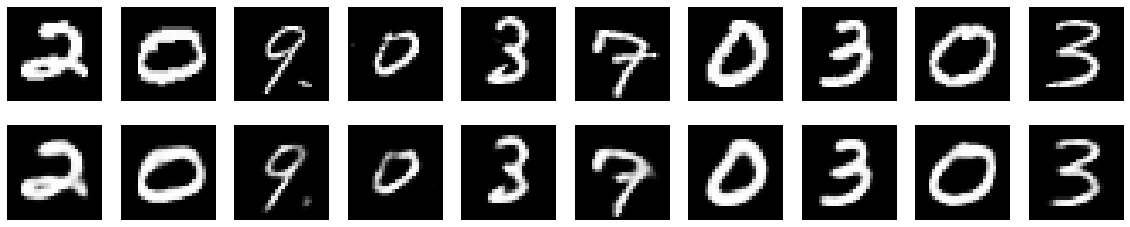

In [19]:
test_data = np.loadtxt("/content/datalab/test.csv", skiprows=1, delimiter=',')
x_test = test_data/255

decoded_imgs = model.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
#save model
!mkdir /tmp/keras
model.save('/tmp/keras/model.h5')
#encoder_model.save('/tmp/keras/encoder.h5')
#decoder_model.save('/tmp/keras/decoder.h5')


mkdir: cannot create directory ‘/tmp/keras’: File exists


In [24]:
filename = "keras" #@param {type:"string"}
folders_or_files_to_save = "/tmp/keras" #@param {type:"string"}
from google.colab import files
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

def save_file_to_drive(name, path):
    file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
    }

    media = MediaFileUpload(path, 
                  mimetype='application/octet-stream',
                  resumable=True)

    created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created


extension_zip = ".zip"

zip_file = filename + extension_zip

# !rm -rf $zip_file
!zip -r $zip_file {folders_or_files_to_save} # FOLDERS TO SAVE INTO ZIP FILE

auth.authenticate_user()
drive_service = build('drive', 'v3')

destination_name = zip_file
path_to_file = zip_file
save_file_to_drive(destination_name, path_to_file)

  adding: tmp/keras/ (stored 0%)
  adding: tmp/keras/model.h5 (deflated 10%)
File ID: 1prNH07UC-2OuwwiexZKE4UBAgcJZL2To


{'id': '1prNH07UC-2OuwwiexZKE4UBAgcJZL2To'}